In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision
from torchvision import transforms
import os
from datetime import datetime  # For generating timestamped folder names
from CNN_autoencoder_model import *
from fully_connected_autoencoder_model import *
from tqdm.auto import tqdm

In [2]:
# Define parameters in a dictionary
params = {
    'num_epochs': 30,
    'batch_size': 32,
    'learning_rate': 0.003,
    'lambda_value': [2,32],
    'save_dir_fc': 'model_ckpts_FC',
    'save_dir_cnn': 'model_ckpts_CNN',
    'loss_criterion': nn.L1Loss(),
    'training_split': 0.1
}

# Check if GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Load MNIST dataset and apply transformations
def load_mnist_data():
    #normalize to 0->1
    transform = transforms.Compose([transforms.ToTensor()])
    mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    return mnist_dataset

# Create data loader for training data
def create_data_loaders(dataset):
    train_loader = DataLoader(dataset, batch_size=params['batch_size'], shuffle=True)
    num_samples = len(dataset)
    test_sampler = SubsetRandomSampler(range(int(0.1 * num_samples), num_samples))
    test_loader = DataLoader(dataset, batch_size=params['batch_size'], sampler=test_sampler)
    return train_loader, test_loader


In [4]:
# get data loaders
for directory in [params['save_dir_fc'], params['save_dir_cnn']]:
    os.makedirs(directory, exist_ok=True)
    for Lambda in params['lambda_value']:
        os.makedirs(os.path.join(directory, str(Lambda)) , exist_ok = True)

mnist_dataset = load_mnist_data()
train_loader, test_loader = create_data_loaders(mnist_dataset)

In [5]:
def train_model(Lambda, model, train_loader, num_epochs, save_dir, resume_checkpoint=None, old_training_loss=None, old_epoch_numbers=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    criterion = params['loss_criterion']  # L1 loss
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

    if resume_checkpoint:
        checkpoint = torch.load(resume_checkpoint)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Model checkpoint loaded, will resume the epochs from number #{start_epoch}")
    else:
        start_epoch = 0

    # Custom progress bar for total epochs with color and displaying average epoch loss
    total_progress_bar = tqdm(total=num_epochs, desc=f"Total Epochs", position=0, bar_format="{desc}: {percentage}% |{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]", dynamic_ncols=True, ncols=100, colour='red')

    # Lists to store training loss and epoch number
    training_loss = old_training_loss if old_training_loss else []
    epoch_numbers = old_epoch_numbers if old_epoch_numbers else []

    checkpointed_paths = []
    for epoch in range(start_epoch, start_epoch + num_epochs):
        model.train()
        total_loss = 0.0

        # Custom progress bar for each epoch with color
        epoch_progress_bar = tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{start_epoch + num_epochs}", position=1, leave=False, dynamic_ncols=True, ncols=100, colour='green')

        for batch_idx, data in enumerate(train_loader):
            images, _ = data
            images = images.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Update the epoch progress bar (overwrite in place)
            epoch_progress_bar.set_postfix(loss=loss.item())
            epoch_progress_bar.update(1)

        # Close the epoch progress bar
        epoch_progress_bar.close()

        # Calculate average loss for the epoch
        average_loss = total_loss / len(train_loader)

        # Append training loss and epoch number to lists
        training_loss.append(average_loss)
        epoch_numbers.append(epoch + 1)

        # Print and save checkpoint
        print(f'Epoch {epoch + 1} Loss: {average_loss}')

        # Update the total progress bar
        total_progress_bar.set_postfix(loss=average_loss)
        total_progress_bar.update(1)

        # Save only once in 5 epochs
        if (epoch + 1) % 5 == 0:
            # Checkpoint the model at the end of each epoch
            checkpoint_path = os.path.join(save_dir, str(Lambda), f'model_epoch_{epoch + 1}.pt')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': average_loss,
            }, checkpoint_path)
            checkpointed_paths.append(f"Checkpointed the model at the path {checkpoint_path}")

    # Close the total progress bar
    total_progress_bar.close()

    # Print what was checkpointed
    for checkpoint_path in checkpointed_paths:
        print(checkpoint_path)

    # Return training loss and epoch numbers for plotting
    return training_loss, epoch_numbers


# Lambda value of 2 for FC autoencoder

In [30]:
#DONT RUN as its already trained!

lambda_2_fc_autoencoder = FC_Autoencoder(params['lambda_value'][0]).to(device)

In [ ]:
#DONT RUN as its already trained!

lambda_2_training_loss, lambda_2_epoch_numbers = train_model(params['lambda_value'][0], lambda_2_fc_autoencoder, train_loader, params['num_epochs'], params['save_dir_fc'])

# Each epoch's loss bar is not shown here!

# Lambda value of 32 for FC autoencoder

In [28]:
#DONT RUN as its already trained!

lambda_32_fc_autoencoder = FC_Autoencoder(params['lambda_value'][1]).to(device)

In [ ]:
#DONT RUN as its already trained!

lambda_32_training_loss, lambda_32_epoch_numbers = train_model(params['lambda_value'][1], lambda_32_fc_autoencoder, train_loader, params['num_epochs'],params['save_dir_fc'])

# Testing the model results

### Code for plotting results

In [6]:
#some common functions related to plotting
import matplotlib.pyplot as plt
import random

# Function to plot original and reconstructed images
def plot_original_vs_reconstructed(model, data_loader, num_samples=5):
    model.eval()

    # Get random samples
    sample_indices = random.sample(range(len(data_loader.dataset)), num_samples)

    # Create a subplot grid
    fig, axes = plt.subplots(2, num_samples, figsize=(12, 4))

    with torch.no_grad():
        for i, idx in enumerate(sample_indices):
            # Get a random sample from the data loader
            sample_data, _ = data_loader.dataset[idx]

            # Forward pass through the model
            reconstructed_data = model(sample_data.unsqueeze(0).to(device))
            print(reconstructed_data)

            # Plot original image
            axes[0, i].imshow(sample_data.squeeze().cpu(), cmap='gray')
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')

            # Plot reconstructed image
            axes[1, i].imshow(reconstructed_data.squeeze().cpu(), cmap='gray')
            axes[1, i].set_title('Reconstructed')
            axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

def plot_training_loss(lamb_2_training_loss, lamb_2_epochs, lamb_32_training_loss, lamb_32_epochs):
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))

    # Plot data on each subplot and add labels
    axes[0].plot(lamb_2_epochs, lamb_2_training_loss)
    axes[0].set_title(f'Lambda2: Training Loss vs Epochs')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Training Loss')

    axes[1].plot(lamb_32_epochs, lamb_32_training_loss)
    axes[1].set_title(f'Lambda32: Training Loss vs Epochs')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Training Loss')

    # Add space between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

    #close it properly
    plt.clf()
    plt.cla()
    plt.close()


### Lambda = 2 reconstruction samples

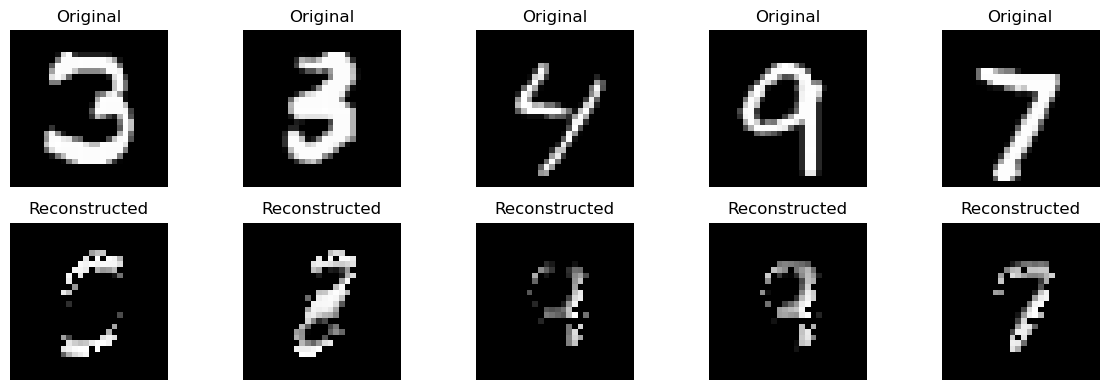

In [39]:
plot_original_vs_reconstructed(lambda_2_fc_autoencoder, test_loader, num_samples=5)

### Lambda = 32 reconstruction samples

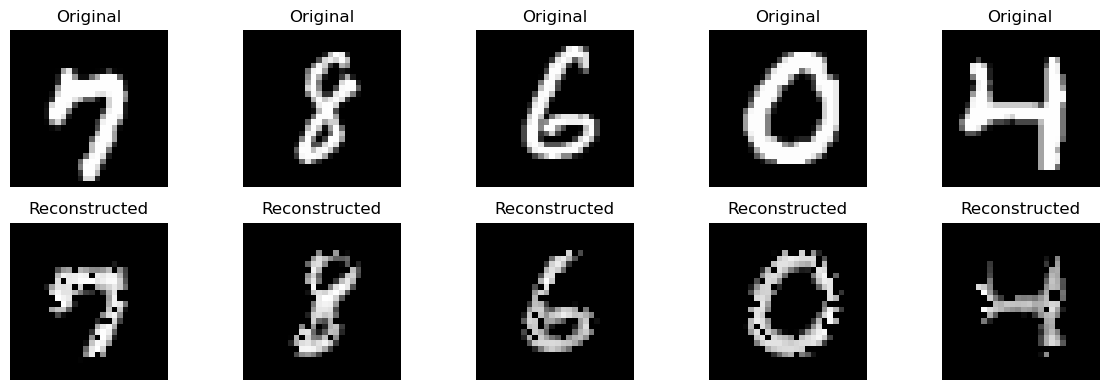

In [38]:
plot_original_vs_reconstructed(lambda_32_fc_autoencoder, test_loader, num_samples=5)

# Plotting training loss vs epochs for each Lambda value


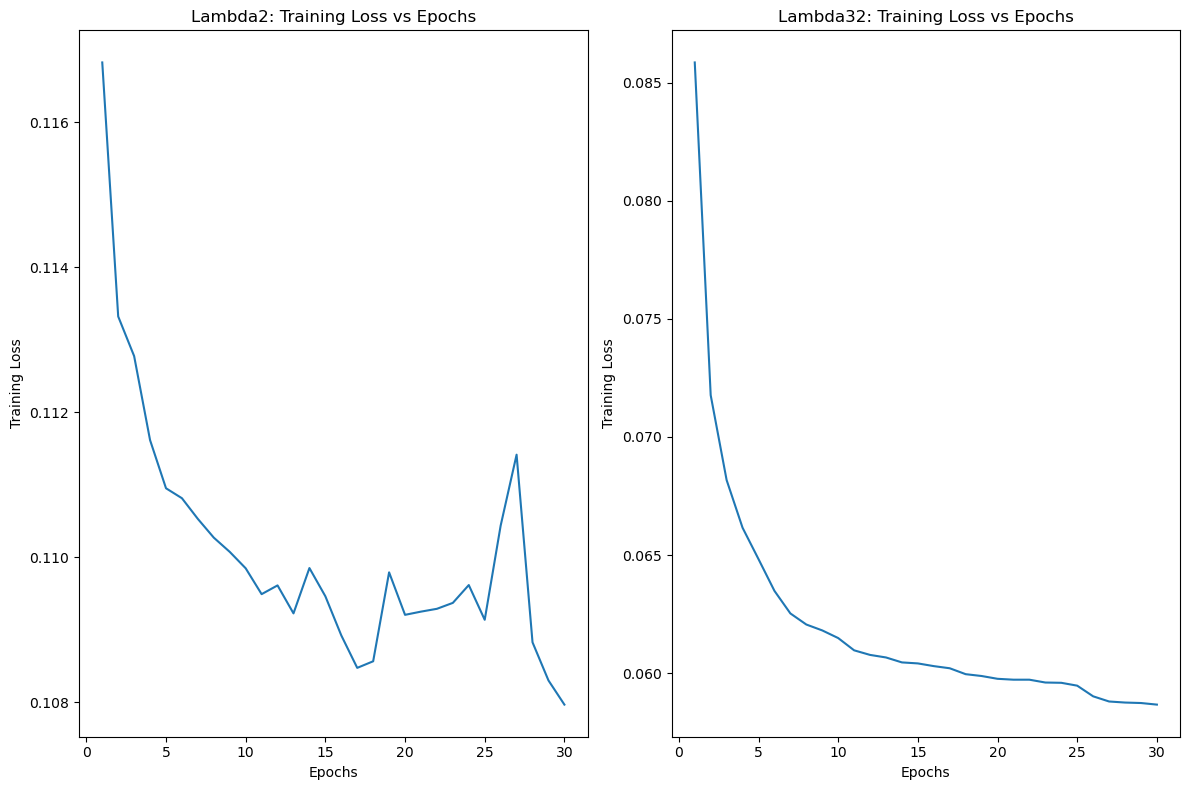

In [40]:
plot_training_loss(lambda_2_training_loss, lambda_2_epoch_numbers, lambda_32_training_loss, lambda_32_epoch_numbers)

# Interpretation


### Reconstruction Interpretation

It is clear that for lambda 32 the reconstruction is much better than lambda 2. The reason for that is because it is better to have a latent feature dimension size of 32 instead of 2 as that is a more natural fit encoded/compressed representation of an mnist image.

For the lambda2 model many times even the reconstruction does not match the ground truth as representing 10 different classes of digits in just a small latent dimension of 2 can confuse the model when it attempts to pass it through the decoder.

On the other hand for lambda 32 the reconstruction images are very good and follows the exact shape of the ground truth image ( just that it has some minor holes which indicates that there is still scope for improving this model)


### Training loss vs epochs Interpretation

For the lambda 32 model, the loss is consistently decreasing as there is a lot of scope for the model to learn the latent features better as a latent dimension of 32 is a much better fir than latent dimension of size 2.

For the lambda 2 model, the training loss is much more erratic which indicates that the model is getting confused or rather learning something and then quickly unlearning and relearning the same concepts again. This is primarily because of the fact that since the latent dimension is very small the distance between the encoded representation of each class is very close in the latent space. Therefore the model does not clearly know how to proceed decoding this image which is why it gives the wrong reconstruction for an entirely different image at times.